In [19]:
import numpy as np

import astropy.units as u
from astropy.io import votable
from astropy.wcs import WCS
from baselines import nbaselines, iterbaselines
from astro import haversine
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
#from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
pair_day1 = votable.parse_single_table("pair_day1.vot").to_table()
pair_day3 = votable.parse_single_table("pair_day3.vot").to_table()
cme_nocme = votable.parse_single_table("cme_nocme.vot").to_table()
nocme_nocme = votable.parse_single_table("nocme_nocme.vot").to_table()

In [3]:
print pair_day1.colnames
print pair_day3.colnames
print cme_nocme.colnames
print nocme_nocme.colnames

['Source_name_tgss', 'RA_tgss', 'DEC_tgss', 'elongation', 'nsi_1', 'err_nsi_1', 'RA_tgss_2', 'DEC_tgss_2', 'elongation_2', 'nsi_2', 'err_nsi_2']
['Source_name_tgss', 'RA_tgss', 'DEC_tgss', 'elongation', 'nsi_1', 'err_nsi_1', 'RA_tgss_2', 'DEC_tgss_2', 'elongation_2', 'nsi_2', 'err_nsi_2']
['Source_name_tgss', 'RA_tgss', 'DEC_tgss', 'elongation', 'nsi_1', 'err_nsi_1', 'RA_tgss_2', 'DEC_tgss_2', 'elongation_2', 'nsi_2', 'err_nsi_2']
['Source_name_tgss', 'RA_tgss', 'DEC_tgss', 'elongation', 'nsi_1', 'err_nsi_1', 'RA_tgss_2', 'DEC_tgss_2', 'elongation_2', 'nsi_2', 'err_nsi_2']


In [4]:
# writing my own fits header parser: a terrible idea!
header ={}
for line in open("/home/jmorgan/tma/1147280248_header.txt"):
    line = line[:30].split('=')
    if not len(line) == 2:
        continue
    if line[1].strip().startswith("'"):
        line[1] = line[1].strip()[1:-1].strip()
    try:
        header[line[0].strip()] = float(line[1].strip())
    except:
        header[line[0].strip()] = line[1].strip()
        
print header
wcs = WCS(header)
print wcs.celestial

{'EXTEND': 'T', 'SIMPLE': 'T', 'CDELT1': 0.3515625, 'CDELT2': 0.3515625, 'CDELT3': 15360000.0, 'CDELT4': 1.0, 'NAXIS': 4.0, 'DATE-OBS': '2015-04-29T00:36:5', 'SUNBEAM': 0.000459827104350552, 'SUNRA': 55.01917498838092, 'BITPIX': -32.0, 'NAXIS1': 120.0, 'NAXIS3': 1.0, 'NAXIS2': 120.0, 'NAXIS4': 1.0, 'SUNDEC': 19.55461406521493, 'BEAMMAX': 0.6458600163459778, 'CRVAL3': 158060000.0, 'CRPIX4': 1.0, 'CRVAL4': -5.0, 'CRVAL2': 0.0, 'CRPIX1': 566.0, 'CRPIX2': 278.0, 'CRPIX3': 1.0, 'CRVAL1': 0.0, 'CTYPE4': 'STOKES', 'CTYPE3': 'FREQ', 'CTYPE2': 'DEC--AIT', 'CTYPE1': 'RA---AIT'}
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AIT'  'DEC--AIT'  
CRVAL : 0.0  0.0  
CRPIX : 566.0  278.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.3515625  0.3515625  
NAXIS : 120.0  120.0  1.0  1.0


In [5]:
def unwrap(a, wrap=180):
    return np.where(a>wrap, a-(wrap*2), a)

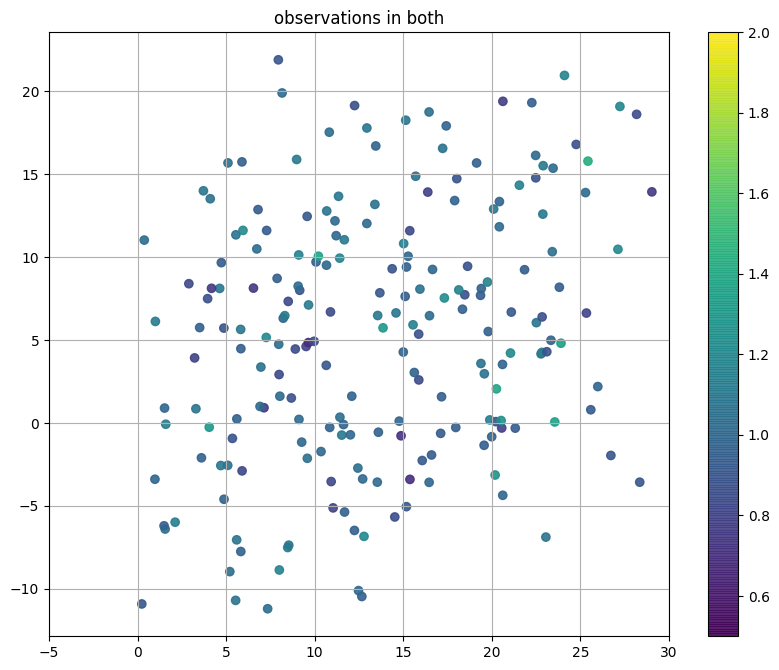

In [6]:
both = ~pair_day1['nsi_1'].mask & ~pair_day1['nsi_2'].mask
cat = pair_day1[both]
plt.figure(figsize=(10,8))
#plt.subplot(111, projection=wcs.celestial)
plt.title("observations in both")
plt.grid(True)
#plt.scatter(cat['RA_tgss'], cat['DEC_tgss'], c =cat['nsi_1']/cat['nsi_2'], 
#            alpha=0.9, cmap=plt.cm.get_cmap('viridis'), norm=LogNorm(vmin=0.5, vmax=2.0)) 
plt.scatter(cat['RA_tgss'], cat['DEC_tgss'], c =cat['nsi_1']/cat['nsi_2'], 
            alpha=0.9, cmap=plt.cm.get_cmap('viridis'), vmax=2, vmin=0.5) 

#plt.subplots_adjust(top=0.95,bottom=0.0)
plt.xlim(-5, 30)
plt.clim(0.5, 2)
plt.colorbar()
#plt.grid()
    

In [7]:
dist = np.zeros(nbaselines(len(cat)))
corr = np.zeros(nbaselines(len(cat)))
for i, (j, k) in enumerate(iterbaselines(range(len(cat)))):
    dist[i] = haversine(np.radians(cat['RA_tgss'][j]), np.radians(cat['DEC_tgss'][j]), 
                        np.radians(cat['RA_tgss'][k]), np.radians(cat['DEC_tgss'][k]))
    corr[i] = cat['nsi_1'][j]/cat['nsi_2'][j]/(cat['nsi_1'][k]/cat['nsi_2'][k])

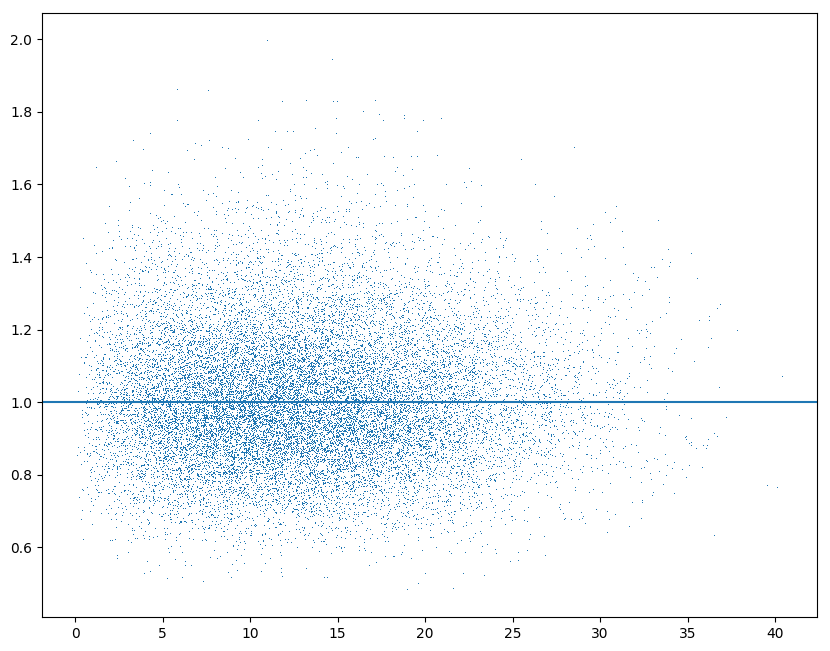

In [8]:
plt.figure(figsize=(10,8))
plt.plot(np.degrees(dist), corr, ',')
plt.axhline(1.0)

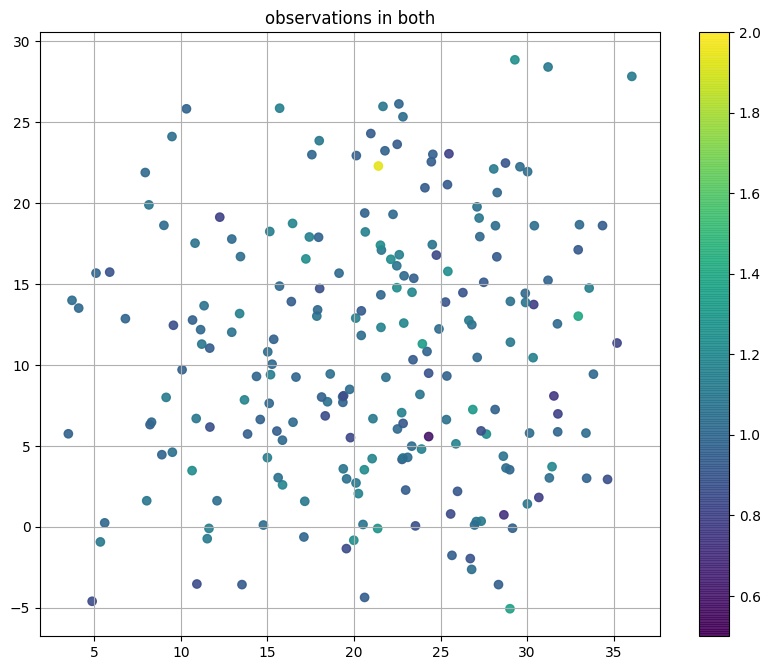

In [9]:
both = ~pair_day3['nsi_1'].mask & ~pair_day3['nsi_2'].mask
cat = pair_day3[both]
plt.figure(figsize=(10,8))
#plt.subplot(111, projection=wcs.celestial)
plt.title("observations in both")
plt.grid(True)
plt.scatter(cat['RA_tgss'], cat['DEC_tgss'], c =cat['nsi_1']/cat['nsi_2'], 
            alpha=0.9, cmap=plt.cm.get_cmap('viridis'), vmax=2, vmin=0.5) 
#plt.subplots_adjust(top=0.95,bottom=0.0)
plt.clim(0.5, 2)
plt.colorbar()
#plt.grid()

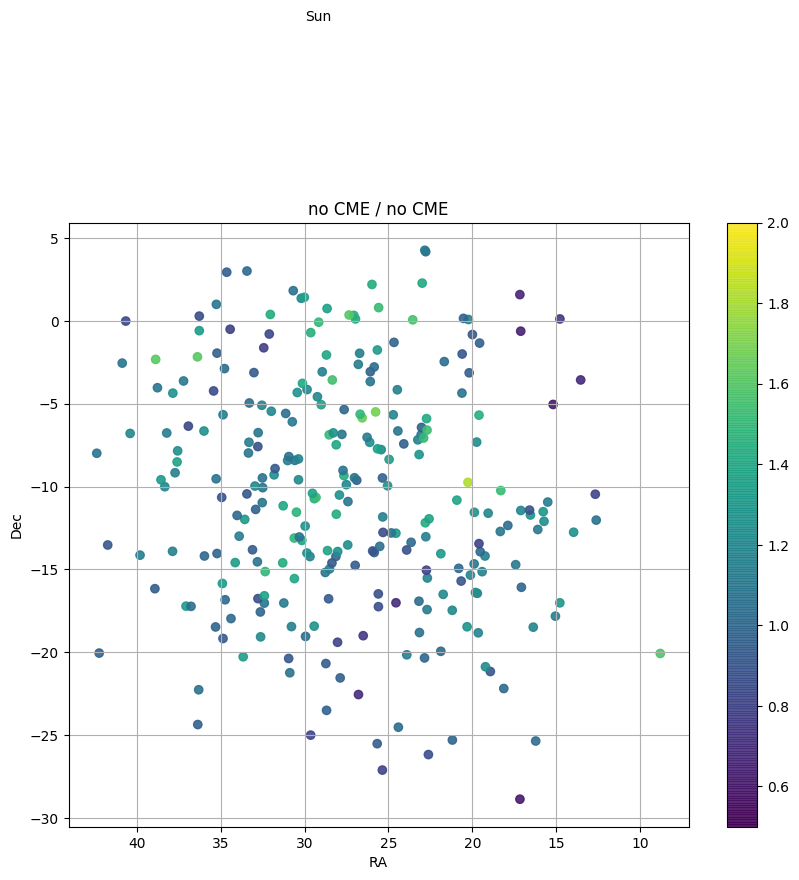

In [10]:
both = ~nocme_nocme['nsi_1'].mask & ~nocme_nocme['nsi_2'].mask
cat = nocme_nocme[both]
#cat1 = nocme_nocme[nocme_nocme['nsi_2'].mask]
#cat2 = nocme_nocme[nocme_nocme['nsi_1'].mask]


plt.figure(figsize=(10,8))
#plt.subplot(111, projection=wcs.celestial)
plt.title("no CME / no CME")
plt.grid(True)
#plt.scatter(cat['RA_tgss'], cat['DEC_tgss'], c =cat['nsi_2']/cat['nsi_1'], 
#            alpha=0.9, cmap=plt.cm.get_cmap('viridis'), norm=LogNorm(vmin=0.5, vmax=2.0)) 
plt.scatter(cat['RA_tgss'], cat['DEC_tgss'], c =cat['nsi_2']/cat['nsi_1'], 
            alpha=0.9, cmap=plt.cm.get_cmap('viridis'), vmax=2, vmin=0.5) 

#plt.scatter(unwrap(cat1['RA_tgss']), cat1['DEC_tgss'], c = np.zeros(len(cat1)), marker='x',
#            alpha=0.9) 
#plt.scatter(unwrap(cat2['RA_tgss']), cat2['DEC_tgss'], c = np.zeros(len(cat2)), marker='+',
#            alpha=0.9) 
plt.gca().invert_xaxis()

plt.arrow(28.5, 19.1, 1.5, 0, width=0.2)
plt.text(30, 18.1, "Sun")
plt.xlabel("RA")
plt.ylabel("Dec")

#plt.subplots_adjust(top=0.95,bottom=0.0)
plt.clim(0.5, 2)
plt.colorbar()
#plt.grid()
plt.savefig("nocme_nocme.png", dpi=160)


In [11]:
dist = np.zeros(nbaselines(len(cat)))
corr = np.zeros(nbaselines(len(cat)))
for i, (j, k) in enumerate(iterbaselines(range(len(cat)))):
    dist[i] = haversine(np.radians(cat['RA_tgss'][j]), np.radians(cat['DEC_tgss'][j]), 
                        np.radians(cat['RA_tgss'][k]), np.radians(cat['DEC_tgss'][k]))
    corr[i] = cat['nsi_1'][j]/cat['nsi_2'][j]/(cat['nsi_1'][k]/cat['nsi_2'][k])

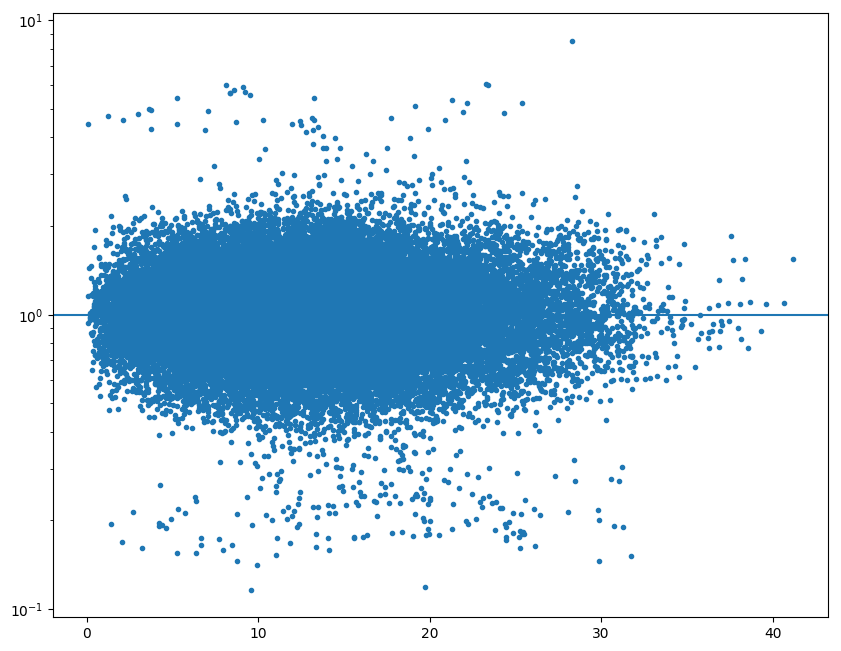

In [16]:
plt.figure(figsize=(10,8))
plt.semilogy(np.degrees(dist), corr, '.')
plt.axhline(1.0)

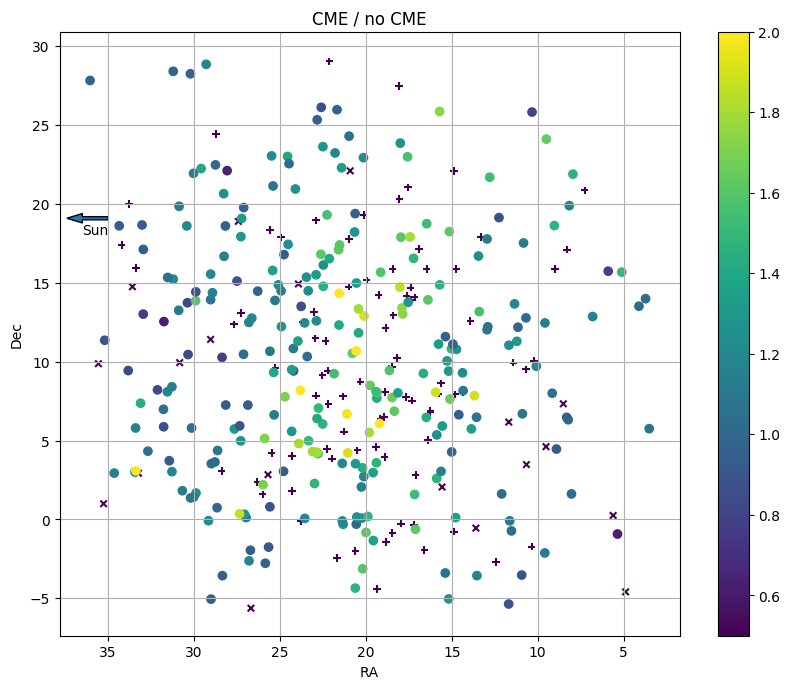

In [13]:
both = ~cme_nocme['nsi_1'].mask & ~cme_nocme['nsi_2'].mask
cat = cme_nocme[both]
cat1 = cme_nocme[cme_nocme['nsi_2'].mask]
cat2 = cme_nocme[cme_nocme['nsi_1'].mask]

plt.figure(figsize=(10,8))
#plt.subplot(111, projection=wcs.celestial)
plt.title("CME / no CME")
plt.grid(True)

plt.scatter(cat1['RA_tgss'], cat1['DEC_tgss'], c = np.zeros(len(cat1)), marker='x',
            s=22) 
plt.scatter(cat2['RA_tgss'], cat2['DEC_tgss'], c = np.zeros(len(cat2)), marker='+',
            s=30) 
plt.scatter(cat['RA_tgss'], cat['DEC_tgss'], c =cat['nsi_2']/cat['nsi_1'], 
            alpha=1.0, cmap=plt.cm.get_cmap('viridis'), vmax=2, vmin=0.5) 


plt.clim(0.5, 2)

plt.gca().invert_xaxis()
#plt.subplots_adjust(top=0.95,bottom=0.0)
plt.colorbar()
plt.arrow(35, 19.1, 1.5, 0, width=0.2)
plt.text(36.5, 18.1, "Sun")
plt.xlabel("RA")
plt.ylabel("Dec")
plt.savefig("cme_nocme_single_detections.png", dpi=160)
#plt.savefig("cme_nocme.png", dpi=160)


In [14]:
dist = np.zeros(nbaselines(len(cat)))
corr = np.zeros(nbaselines(len(cat)))
for i, (j, k) in enumerate(iterbaselines(range(len(cat)))):
    dist[i] = haversine(np.radians(cat['RA_tgss'][j]), np.radians(cat['DEC_tgss'][j]), 
                        np.radians(cat['RA_tgss'][k]), np.radians(cat['DEC_tgss'][k]))
    corr[i] = cat['nsi_1'][j]/cat['nsi_2'][j]/(cat['nsi_1'][k]/cat['nsi_2'][k])

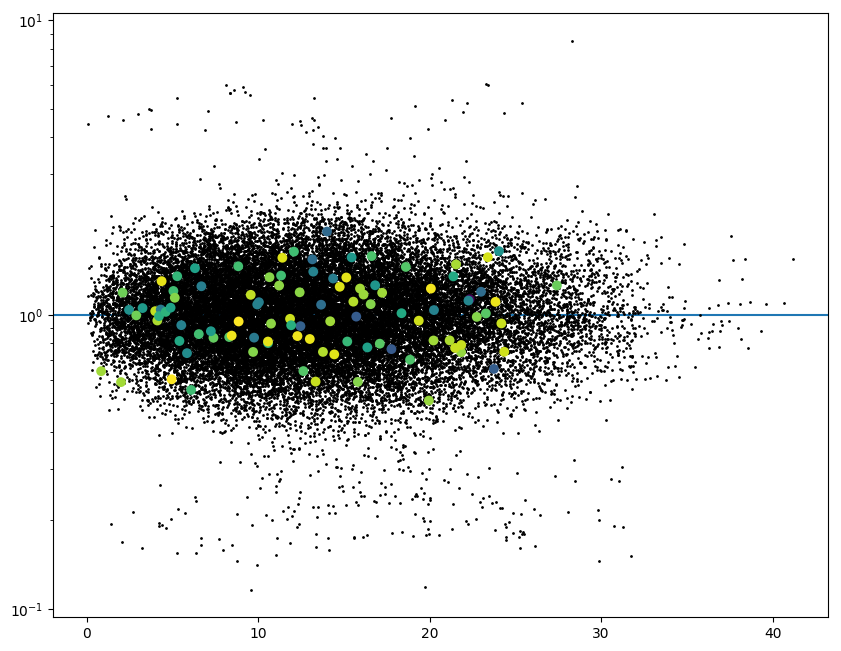

In [25]:
decimate=100
plt.figure(figsize=(10,8))
plt.semilogy(np.degrees(dist), corr, '.', markersize=2, alpha=1.0, color='black', zorder=10)
N = len(dist)
skip = N // decimate
#xy = np.vstack([dist, corr])
#z = gaussian_kde(xy)(xy)
sort = np.argsort(z[::skip])
plt.scatter(np.degrees(dist[::skip][sort]), corr[::skip][sort], c=z[sort], s=50, edgecolor='', zorder=20)
plt.axhline(1.0)

Do this again but break down into two dimensions (radial and tangential to Sun